In [4]:
import os, sys
import numpy as np
from PIL import Image
from dataclasses import dataclass
from datasets import load_dataset

import torch
import torch.nn as nn
from transformers import (
    GPT2Model, GPT2Tokenizer,
    
    CLIPVisionModel, CLIPProcessor,
    
    TrainingArguments, Trainer,
    
    logging
)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

if device.type == "cuda":
    print(torch.cuda.get_device_name(0))

cuda
NVIDIA GeForce RTX 3090


In [6]:
dataset = load_dataset(
    "csv",
    data_files={
        "train": "../CLIP-GPT2/data/clip-gpt2/train.csv",
        "test": "../CLIP-GPT2/data/clip-gpt2/test.csv"
    }
)

Using custom data configuration default-1dc51d6c043d41c7


Generating train split: 0 examples [00:00, ? examples/s]

c:\Users\Keenan Samway\miniconda3\envs\pytorch\lib\site-packages\datasets\download\streaming_download_manager.py:714: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  return pd.read_csv(xopen(filepath_or_buffer, "rb", use_auth_token=use_auth_token), **kwargs)


Generating test split: 0 examples [00:00, ? examples/s]

c:\Users\Keenan Samway\miniconda3\envs\pytorch\lib\site-packages\datasets\download\streaming_download_manager.py:714: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  return pd.read_csv(xopen(filepath_or_buffer, "rb", use_auth_token=use_auth_token), **kwargs)


Dataset csv downloaded and prepared to C:/Users/Keenan Samway/.cache/huggingface/datasets/csv/default-1dc51d6c043d41c7/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [21]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image_id', 'caption'],
        num_rows: 1184167
    })
    test: Dataset({
        features: ['image_id', 'caption'],
        num_rows: 131575
    })
})

In [26]:
def showExample(id=None):
    data = dataset["test"]
    
    if id is None:
        id = torch.randint(len(data['image_id']), size=(1,)).item()
    
    img = Image.open(os.path.join("../datasets/AVA/images", data[id]['image_id']))
    print("Caption:", data[id]['caption'])
    display(img)
    

Caption: i love this one. it is definitely pink in the middle, but the blue tones make it really unique. it's beautiful. and it's pretty hard to get me wow'ed by a flower shot.


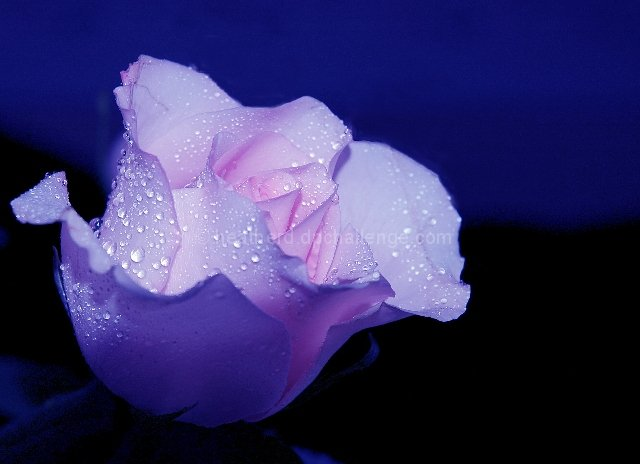

In [28]:
showExample()

In [ ]:
@dataclass
class MyCollator:
    tokenizer: GPT2Tokenizer
    processor: CLIPProcessor
    
    def tokenize_text(self, texts):
        encoded_text = self.tokenizer(
            texts,
            return_tensors="pt",
        )
        return {
            "input_ids": encoded_text["input_ids"].squeeze(),
        }
        
    def process_image(self, images):
        processed_images = self.processor(
            images=[Image.open(os.path.join("..", "datasets/AVA/images", image_id)).convert('RGB') for image_id in images],
            return_tensors="pt",
            )
        return {
            "pixel_values": processed_images["pixel_values"].squeeze(),
        }
    
    def __call__(self, raw_batch_dict):
        return {
            **self.tokenize_text(
                raw_batch_dict['caption']
                if isinstance(raw_batch_dict, dict) else
                [i['caption'] for i in raw_batch_dict]
            ),
            **self.process_image(
                raw_batch_dict['image_id']
                if isinstance(raw_batch_dict, dict) else
                [i['image_id'] for i in raw_batch_dict]
            ),
            'labels': torch.tensor(
                raw_batch_dict['label']
                if isinstance(raw_batch_dict, dict) else
                [i['label'] for i in raw_batch_dict],
                dtype=torch.int64
            ),
        }

In [ ]:
class MultimodalFusionModel(nn.Module):
    def __init__(self, text_model, image_model, vocab_size, embed_dim=512, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.vocab_size = vocab_size
        self.text_model = text_model
        self.image_model = image_model
        
        # Pretrained transformers for encoding text and image
        with torch.no_grad():
            self.text_encoder = GPT2Model.from_pretrained(text_model)
            self.image_encoder = CLIPVisionModel.from_pretrained(image_model)
        
        self.fusion = nn.Sequential(
            nn.Linear(self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_size, self.embed_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        
        self.classifier = nn.Linear(self.embed_dim, self.vocab_size)
        
        self.criterion = nn.CrossEntropyLoss()
        
    def forward(self, captions, images):
        encoded_text = self.text_encoder(captions, return_dict=True)
        
        encoded_images = self.image_encoder(images, return_dict=True)
        
        fused_output = self.fusion(
            torch.cat([encoded_text['last_hidden_states']], [encoded_images['pooler_output']], dim=1)
        )
        
        logits = self.classifier(fused_output)
        
        out = {"logits": logits}
        
        loss = self.criterion(logits, )
        out["loss"] = loss
        
        return out

In [ ]:
def createCollatorAndModel(text="gpt2", image="openai/clip-vit-base-patch32"):
    tokenizer = GPT2Tokenizer.from_pretrained(text)
    processor = CLIPProcessor.from_pretrained(image)
    
    mycollator = MyCollator(tokenizer=tokenizer, processor=processor)
    
    model = MultimodalFusionModel(text, image).to(device)
    
    return mycollator, model

In [ ]:
args = TrainingArguments(
    output_dir="../CLIP-GPT2/models/clip-b32_gpt2-large/",
    seed=42,
    evaluation_strategy="steps",
    eval_steps=1000,
    logging_strategy="steps",
    logging_steps=1000,
    save_strategy="steps",
    save_steps=1000,
    save_total_limit=3,
    metric_for_best_model="eval_loss",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    fp16=True,
    fp16_opt_level="O1",
    # warmup_ratio=0.01,
    # leraning_rate=5e-4,
    # weight_decay=1e-4,
    # gradient_accumulation_steps=2,
    dataloader_num_workers=4,
    load_best_model_at_end=True,
)

In [ ]:
collator, model = createCollatorAndModel('gpt2', 'openai/clip-vit-base-patch32')

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    data_collator=collator,
)

train_metrics = trainer.train()
eval_metrics = trainer.evaluate()